In [ ]:
# Install dependencies
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle scipy==1.10.1

# Inline plots
%matplotlib inline

In [ ]:
!pip install torch

In [ ]:
!pip install torchsummary

In [ ]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI()

# list the datasets and available versions
all_datasets = napi.list_datasets()
dataset_versions = list(set(d.split('/')[0] for d in all_datasets))
print("Available versions:\n", dataset_versions)

# Set data version to one of the latest datasets
DATA_VERSION = "v4.3"

# Print all files available for download for our version
current_version_files = [f for f in all_datasets if f.startswith(DATA_VERSION)]
print("availbable", DATA_VERSION, "files:\n", current_version_files)

Available versions:
 ['v4.1', 'v4.3', 'v4.2', 'v4']
availbable v4.3 files:
 ['v4.3/features.json', 'v4.3/live_benchmark_models.parquet', 'v4.3/live_example_preds.csv', 'v4.3/live_example_preds.parquet', 'v4.3/live_int8.parquet', 'v4.3/meta_model.parquet', 'v4.3/train_benchmark_models.parquet', 'v4.3/train_int8.parquet', 'v4.3/validation_benchmark_models.parquet', 'v4.3/validation_example_preds.csv', 'v4.3/validation_example_preds.parquet', 'v4.3/validation_int8.parquet']


In [ ]:
import json

# download the feature metadata file
napi.download_dataset(f"{DATA_VERSION}/features.json");

# read the metadata and display
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
for metadata in feature_metadata:
  print(metadata, len(feature_metadata[metadata]))

2024-04-14 15:06:29,770 INFO numerapi.utils: target file already exists
2024-04-14 15:06:29,771 INFO numerapi.utils: download complete


feature_stats 2376
feature_sets 17
targets 41


In [ ]:
feature_sets = feature_metadata["feature_sets"]
for feature_set in ["small", "medium", "all"]:
  print(feature_set, len(feature_sets[feature_set]))

small 42
medium 705
all 2376


In [ ]:
import pandas as pd

# Define our feature set
feature_set = feature_sets["medium"]
train = pd.read_parquet(
    f"{DATA_VERSION}/train_int8.parquet",
    columns=["era", "target"] + feature_set
)

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data
train = train[train["era"].isin(train["era"].unique()[::4])]

In [ ]:
train

,era,target,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_adam_incantational_winemaker,feature_additive_untrustworthy_hierologist,...,feature_witchy_orange_muley,feature_wombed_liberatory_malva,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yauld_antediluvial_subprefecture,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,feature_zygodactyl_exponible_lathi
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,0.25,0,4,0,4,2,0,2,1,...,0,0,2,4,2,4,3,2,2,3
n003bee128c2fcfc,0001,0.75,4,2,2,2,2,3,2,1,...,3,3,2,0,2,2,1,3,2,1
n0048ac83aff7194,0001,0.25,4,4,2,0,2,0,2,4,...,0,1,2,0,2,3,2,1,2,2
n00691bec80d3e02,0001,0.75,1,4,1,1,2,0,2,2,...,2,1,2,2,2,3,2,2,2,2
n00b8720a2fdc4f2,0001,0.50,0,2,0,0,2,0,2,3,...,1,1,2,0,2,0,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffc2d5e4b79a7ae,0573,0.25,4,2,4,4,3,1,0,0,...,4,1,2,1,3,2,2,2,1,1
nffc7d24176548a4,0573,0.50,0,3,3,4,2,0,2,3,...,2,0,2,4,2,0,2,1,2,3
nffc9844c1c7a6a9,0573,0.50,4,1,1,2,0,3,2,4,...,1,3,0,3,0,2,0,0,1,2


In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from sklearn.model_selection import train_test_split

# Convert pandas dataframe to tensor directly
X_train_tensor = torch.tensor(train[feature_set].values, dtype=torch.float32)
y_train_tensor = torch.tensor(train['target'].values, dtype=torch.float32).view(-1, 1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)

# Create DataLoaders for each set
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, feature_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(feature_dim, 1024),
            nn.BatchNorm1d(1024),
            Swish(),
            nn.Linear(1024, encoding_dim),
            nn.BatchNorm1d(encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 1024),
            nn.BatchNorm1d(1024),
            Swish(),
            nn.Linear(1024, feature_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            Swish(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
FEATURE_DIM = 705  # Ensure this matches your actual feature set size
ENCODING_DIM = 300  # Example encoding dimension

In [ ]:
autoencoder = Autoencoder(FEATURE_DIM, ENCODING_DIM)
mlp = MLP(FEATURE_DIM + ENCODING_DIM)  # Adjust as per your architecture needs

optimizer = torch.optim.Adam(
    list(autoencoder.parameters()) + list(mlp.parameters()), lr=0.001)
ae_criterion = nn.MSELoss()
mlp_criterion = nn.MSELoss()

In [ ]:
best_val_loss = float('inf')
patience = 5
trigger_times = 0
num_epochs = 10

In [ ]:
for epoch in range(num_epochs):
    # Training phase
    autoencoder.train()
    mlp.train()
    for data, targets in train_dataloader:
        optimizer.zero_grad()
        noise = torch.randn_like(data) * 0.1
        noisy_data = data + noise

        encoded, decoded = autoencoder(noisy_data)
        ae_loss = ae_criterion(decoded, data)

        combined_features = torch.cat((encoded, data), dim=1)
        predictions = mlp(combined_features)
        mlp_loss = mlp_criterion(predictions, targets)

        loss = ae_loss + mlp_loss
        loss.backward()
        optimizer.step()

    # Validation phase
    autoencoder.eval()
    mlp.eval()
    val_loss = 0
    with torch.no_grad():
        for data, targets in val_dataloader:
            encoded, decoded = autoencoder(data)
            combined_features = torch.cat((encoded, data), dim=1)
            predictions = mlp(combined_features)
            val_loss += mlp_criterion(predictions, targets).item()

    val_loss /= len(val_dataloader)
    print(f'Epoch {epoch + 1}: Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = {
            'autoencoder': autoencoder.state_dict(),
            'mlp': mlp.state_dict()
        }
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break

Epoch 1: Train Loss: 0.4246, Val Loss: 0.0518
Epoch 2: Train Loss: 0.4354, Val Loss: 0.0499
Epoch 3: Train Loss: 0.3798, Val Loss: 0.0498
Epoch 4: Train Loss: 0.3960, Val Loss: 0.0496
Epoch 5: Train Loss: 0.3880, Val Loss: 0.0497
Epoch 6: Train Loss: 0.3465, Val Loss: 0.0496
Epoch 7: Train Loss: 0.4607, Val Loss: 0.0497
Epoch 8: Train Loss: 0.3472, Val Loss: 0.0497
Epoch 9: Train Loss: 0.3376, Val Loss: 0.0497
Early stopping!


In [ ]:
torch.save(best_model, 'best_model.pth')

In [ ]:
# Initialize the models
autoencoder = Autoencoder(FEATURE_DIM, ENCODING_DIM)
mlp = MLP(FEATURE_DIM + ENCODING_DIM)

# Load the state dictionaries from the saved file
best_model = torch.load('best_model.pth')
autoencoder.load_state_dict(best_model['autoencoder'])
mlp.load_state_dict(best_model['mlp'])

# Set the models to evaluation mode
autoencoder.eval()
mlp.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1005, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Swish()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
autoencoder.to(device)
mlp.to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1005, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Swish()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [ ]:
# Load the validation data and filter for data_type == "validation"
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation_int8.parquet",
    columns=["era", "data_type", "target"] + feature_set
)
validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]

# Downsample to every 4th era to reduce memory usage and speedup evaluation (suggested for Colab free tier)
# Comment out the line below to use all the data (slower and higher memory usage, but more accurate evaluation)
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

In [ ]:
X_validation = torch.tensor(validation[feature_set].values, dtype=torch.float32)
y_validation = torch.tensor(validation['target'].values, dtype=torch.float32).view(-1, 1)

# Create the TensorDataset
validation_dataset = TensorDataset(X_validation, y_validation)

# Create the DataLoader for validation dataset
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

In [ ]:
all_predictions = []
all_targets = []

with torch.no_grad():  # Disable gradient computation during inference
    for data, targets in validation_dataloader:
        # Move data and targets to the correct device
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass through the autoencoder
        encoded, _ = autoencoder(data)  # Assuming the autoencoder returns encoded and decoded tensors

        # Forward pass through the MLP
        # Ensure only the encoded output and data are concatenated
        predictions = mlp(torch.cat((encoded, data), dim=1))

        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calculate Mean Squared Error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(all_targets, all_predictions)
print(f'Mean Squared Error on Validation Set: {mse}')

Mean Squared Error on Validation Set: 0.04989945888519287


##Old version

In [ ]:
train_tensor = torch.tensor(train[feature_set].values, dtype=torch.float32)
target_tensor = torch.tensor(train['target'].values, dtype=torch.float32).view(-1, 1)
dataset = TensorDataset(train_tensor, target_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
# Training loop
num_epochs = 10  # Define the number of epochs
for epoch in range(num_epochs):
    for data, targets in dataloader:
        # Add noise for data augmentation
        noise = torch.randn_like(data) * 0.1
        noisy_data = data + noise

        # Autoencoder operations
        encoded, decoded = autoencoder(noisy_data)
        ae_loss = ae_criterion(decoded, data)

        # Concatenate encoded features with original features
        combined_features = torch.cat((encoded, data), dim=1)
        predictions = mlp(combined_features)
        mlp_loss = mlp_criterion(predictions, targets)

        # Overall loss
        loss = ae_loss + mlp_loss  # Modify this if you need different weighting

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Autoencoder Loss: {ae_loss.item():.4f}, MLP Loss: {mlp_loss.item():.4f}')

Epoch 1, Autoencoder Loss: 0.1971, MLP Loss: 0.0716
Epoch 2, Autoencoder Loss: 0.1736, MLP Loss: 0.0465
Epoch 3, Autoencoder Loss: 0.1911, MLP Loss: 0.0292
Epoch 4, Autoencoder Loss: 0.1929, MLP Loss: 0.0511
Epoch 5, Autoencoder Loss: 0.2000, MLP Loss: 0.0651
Epoch 6, Autoencoder Loss: 0.1872, MLP Loss: 0.0368
Epoch 7, Autoencoder Loss: 0.1979, MLP Loss: 0.0418
Epoch 8, Autoencoder Loss: 0.2080, MLP Loss: 0.0329
Epoch 9, Autoencoder Loss: 0.1938, MLP Loss: 0.0565
Epoch 10, Autoencoder Loss: 0.1833, MLP Loss: 0.0510


In [ ]:
from torchsummary import summary

model = MLP(input_dim=FEATURE_DIM + ENCODING_DIM)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(FEATURE_DIM + ENCODING_DIM,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         515,072
       BatchNorm1d-2                  [-1, 512]           1,024
             Swish-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                    [-1, 1]             513
Total params: 516,609
Trainable params: 516,609
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.97
Estimated Total Size (MB): 1.99
----------------------------------------------------------------


In [ ]:
# Download validation data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/validation_int8.parquet");

# Load the validation data and filter for data_type == "validation"
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation_int8.parquet",
    columns=["era", "data_type", "target"] + feature_set
)
validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]

# Downsample to every 4th era to reduce memory usage and speedup evaluation (suggested for Colab free tier)
# Comment out the line below to use all the data (slower and higher memory usage, but more accurate evaluation)
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

2024-04-14 00:19:05,188 INFO numerapi.utils: target file already exists
2024-04-14 00:19:05,189 INFO numerapi.utils: download complete


In [ ]:
validation

,era,target,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_adam_incantational_winemaker,feature_additive_untrustworthy_hierologist,...,feature_witchy_orange_muley,feature_wombed_liberatory_malva,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yauld_antediluvial_subprefecture,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,feature_zygodactyl_exponible_lathi
id,,,,,,,,,,,,,,,,,,,,,
n002a15bc5575bbb,0579,0.25,3,2,4,2,0,2,0,2,...,4,1,3,1,0,3,2,2,0,2
n00309caaa0f955e,0579,0.50,4,2,0,2,1,2,0,1,...,3,2,0,3,1,2,0,2,0,0
n00576b397182463,0579,0.50,0,1,2,3,0,3,0,2,...,3,2,1,1,4,2,2,4,1,4
n00633405d59c6a1,0579,1.00,4,4,3,2,1,3,4,3,...,2,2,2,3,4,2,4,4,2,1
n008c2eefc8911c7,0579,0.50,2,3,2,1,2,2,0,4,...,2,2,1,0,2,2,2,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffdb6e40e2f845c,1103,0.25,4,0,0,4,3,0,1,3,...,2,0,4,1,3,4,0,2,2,1
nffe7ab06ef8a5a5,1103,0.50,4,0,1,2,1,0,0,0,...,0,0,0,2,0,0,0,0,2,1
nffeddeb986175f9,1103,0.50,2,2,4,1,3,1,2,0,...,2,0,0,0,2,2,4,1,2,2


In [ ]:
X_validation = torch.tensor(validation[feature_set].values, dtype=torch.float32)
y_validation = torch.tensor(validation['target'].values, dtype=torch.float32).view(-1, 1)

# Create a DataLoader for your validation data
validation_dataset = TensorDataset(X_validation, y_validation)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Assuming your model is named 'model'
model.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=705, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Swish()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [ ]:
predictions = []
model.eval()
with torch.no_grad():
    for inputs, _ in validation_dataloader:
        inputs = inputs.to(device)  # Transfer inputs to the same device as model
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())  # Optionally move outputs to CPU

In [ ]:
# Disabling gradient calculation is important for inference, saving memory and computations
with torch.no_grad():
    predictions = []
    for data, _ in validation_dataloader:
        # Move data to the same device as your model
        data = data.to(device)  # device is either "cuda" if using GPU or "cpu"
        output = model(data)
        predictions.append(output.cpu())  # Move predictions to CPU

# Concatenate all batches
predictions = torch.cat(predictions, dim=0)

In [ ]:
predictions

tensor([[ 0.6234],
        [ 0.1821],
        [-0.1195],
        ...,
        [ 0.3940],
        [ 0.4087],
        [ 0.5590]])

In [ ]:
predictions_array = predictions.numpy().flatten()

In [ ]:
predictions_array

array([ 0.6233697 ,  0.18212979, -0.11945754, ...,  0.39399907,
        0.4086981 ,  0.55896   ], dtype=float32)

In [ ]:
predictions_series = pd.Series(predictions_array, index=validation.index)
predictions_series

id
n002a15bc5575bbb    0.623370
n00309caaa0f955e    0.182130
n00576b397182463   -0.119458
n00633405d59c6a1    0.579091
n008c2eefc8911c7    0.893037
                      ...   
nffdb6e40e2f845c    0.474884
nffe7ab06ef8a5a5   -0.513672
nffeddeb986175f9    0.393999
nfff57c896e1912b    0.408698
nfff9dec3b2912f6    0.558960
Length: 671734, dtype: float32

In [ ]:
validation['prediction'] = predictions_series

In [ ]:
# Display the first few rows to verify predictions are correctly aligned
print(validation[['era', 'prediction', 'target']].head())

                   era  prediction  target
id                                        
n002a15bc5575bbb  0579    0.623370    0.25
n00309caaa0f955e  0579    0.182130    0.50
n00576b397182463  0579   -0.119458    0.50
n00633405d59c6a1  0579    0.579091    1.00
n008c2eefc8911c7  0579    0.893037    0.50


In [ ]:
result_df = validation[['era', 'prediction', 'target']]

In [ ]:
result_df

,era,prediction,target
id,,,
n002a15bc5575bbb,0579,0.623370,0.25
n00309caaa0f955e,0579,0.182130,0.50
n00576b397182463,0579,-0.119458,0.50
n00633405d59c6a1,0579,0.579091,1.00
n008c2eefc8911c7,0579,0.893037,0.50
...,...,...,...
nffdb6e40e2f845c,1103,0.474884,0.25
nffe7ab06ef8a5a5,1103,-0.513672,0.50
nffeddeb986175f9,1103,0.393999,0.50


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(result_df['target'], result_df['prediction'])
rmse = mse ** 0.5
mae = mean_absolute_error(result_df['target'], result_df['prediction'])

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

MSE: 0.1442
RMSE: 0.3797
MAE: 0.3025


In [ ]:
# Group by 'era' and calculate performance metrics
era_performance = result_df.groupby('era').apply(
    lambda df: pd.Series({
        'MSE': mean_squared_error(df['target'], df['prediction']),
        'MAE': mean_absolute_error(df['target'], df['prediction'])
    })
)

print(era_performance)

           MSE       MAE
era                     
0579  0.138665  0.295466
0583  0.139745  0.297346
0587  0.141683  0.298604
0591  0.132617  0.288570
0595  0.134020  0.289183
...        ...       ...
1087  0.142784  0.301532
1091  0.141187  0.299133
1095  0.141994  0.300378
1099  0.142803  0.299806
1103  0.150514  0.310175

[132 rows x 2 columns]


2024-04-14 00:28:32,135 INFO matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-14 00:28:32,137 INFO matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


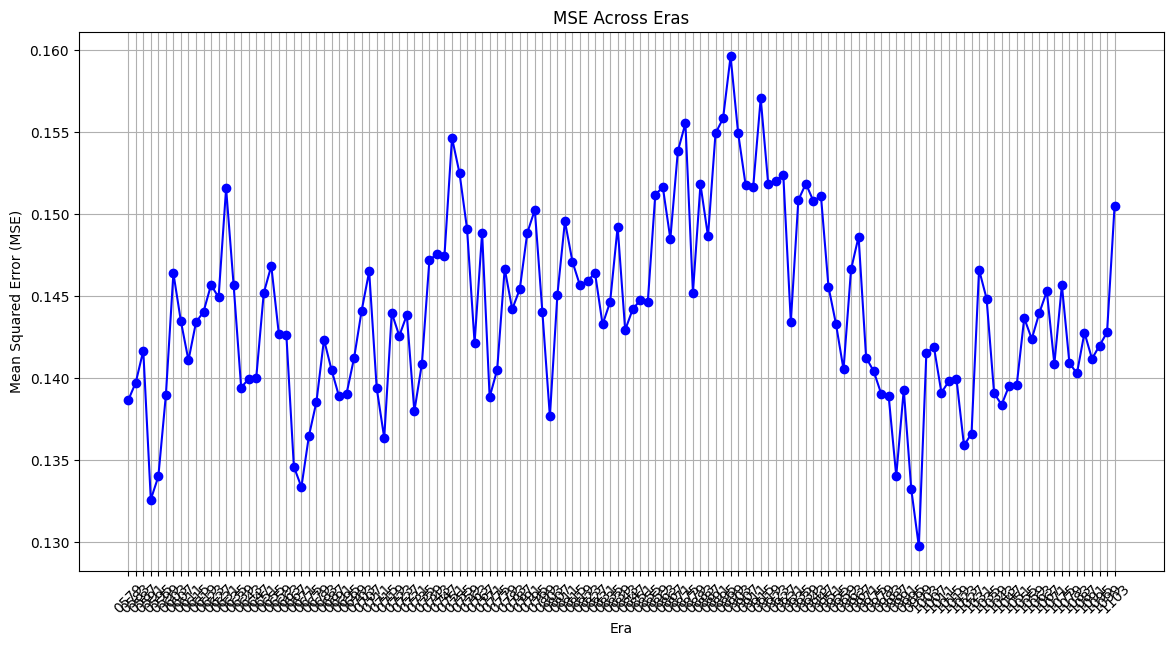

In [ ]:
import matplotlib.pyplot as plt

# Plotting MSE for each era
plt.figure(figsize=(14, 7))  # Set the figure size for better readability
plt.plot(era_performance.index, era_performance['MSE'], marker='o', linestyle='-', color='b')  # Line plot
plt.title('MSE Across Eras')  # Title of the plot
plt.xlabel('Era')  # Label for the x-axis
plt.ylabel('Mean Squared Error (MSE)')  # Label for the y-axis
plt.grid(True)  # Enable grid for better visualization of values
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

2024-04-14 00:34:03,211 INFO matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-14 00:34:03,213 INFO matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


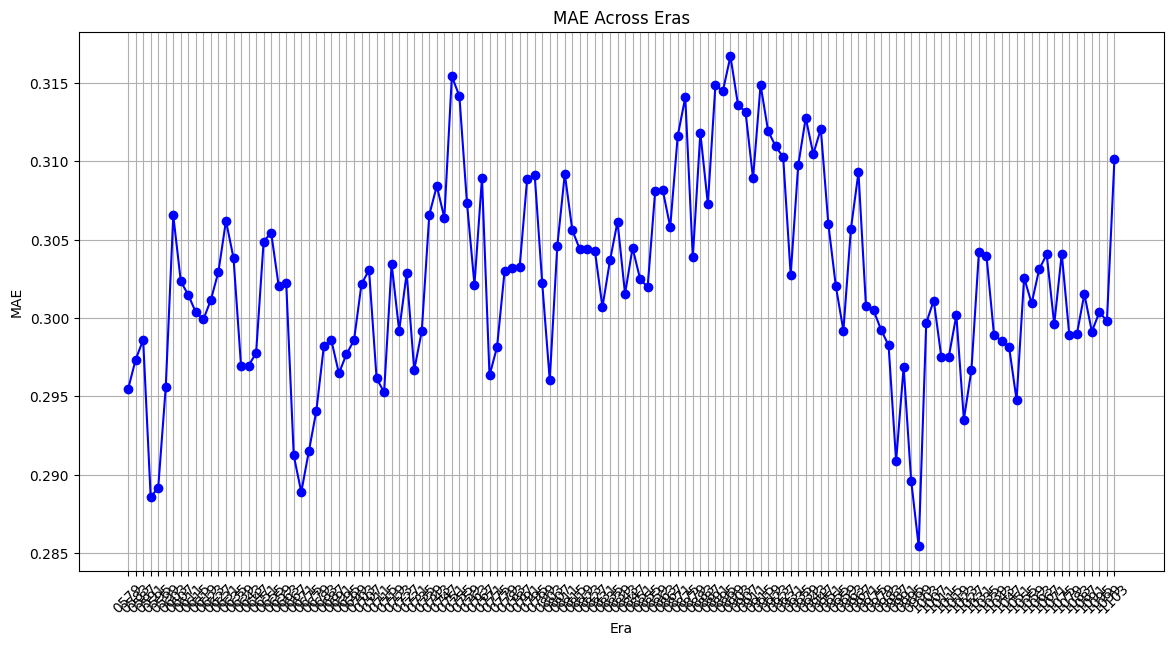

In [ ]:
plt.figure(figsize=(14, 7))  # Set the figure size for better readability
plt.plot(era_performance.index, era_performance['MAE'], marker='o', linestyle='-', color='b')  # Line plot
plt.title('MAE Across Eras')  # Title of the plot
plt.xlabel('Era')  # Label for the x-axis
plt.ylabel('MAE')  # Label for the y-axis
plt.grid(True)  # Enable grid for better visualization of values
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()